In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from utils import hnorm_on_xygrid, gradh_on_xygrid, load_config, default_params, axes_styling, depth_following_contour

## Hva har jeg lært så langt?
- Form stress i kartesiske koordinater: samme resultat om man antar rigid-lid eller inkluderer free surface
- Form stress H kontur: man kan ikke skrive om fra $H\nabla \eta$ til $-\eta \nabla H$.
- Å integrere over x y, eller over C(H) H, gir kalitativt samme resultat.
- Så langt klarer jeg ikke å få de to termene til å bli det samme. men kanskje de ikke skal bli det samme? Dette må jeg tneke på.
- Virvligsfluksen blir ~0 også for dybdekonturer!

In [21]:
config = "slope-006"
xstart = 0
xstop = 90
params = load_config(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/configs/{config}.json", default_params)

ds = xr.open_dataset(f"/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/output/{config}.nc").squeeze()
ds = ds.isel(xC=slice(xstart,xstop),xF=slice(xstart,xstop+1))

area = params["Ly"]*(xstop-xstart)*params["dx"]

In [22]:
hnorm = hnorm_on_xygrid(params, ds)
hnorm

<xarray.Dataset>
Dimensions:  (xC: 90, yC: 90)
Coordinates:
  * xC       (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yC       (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
Data variables:
    dhdxn    (yC, xC) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    dhdyn    (yC, xC) float64 -0.0005063 -0.000609 -0.0007509 ... 0.0 0.0 0.0

In [23]:
hgrad = gradh_on_xygrid(params, ds)
hgrad["dh"] = np.sqrt(hgrad.dhdx**2+hgrad.dhdx**2)
hgrad

<xarray.Dataset>
Dimensions:  (yC: 90, xC: 90)
Coordinates:
  * xC       (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yC       (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
Data variables:
    dhdx     (yC, xC) float64 1.475e-05 1.864e-05 ... 1.247e-11 1.247e-11
    dhdy     (yC, xC) float64 -7.469e-09 -1.135e-08 ... 4.098e-14 4.172e-14
    dh       (yC, xC) float64 2.086e-05 2.636e-05 ... 1.764e-11 1.764e-11

In [24]:
omegau = ds.omegau.values
omegav = ds.omegav.values

omegau = np.insert(omegau, 0, omegau[:,-1,:], axis=1)
omegau = 0.5*(omegau[:,1:,1:]+omegau[:,:-1,:-1])

omegav = np.insert(omegav, 0, omegav[:,-1,:], axis=1)
omegav = 0.5*(omegav[:,1:,1:]+omegav[:,:-1,:-1])

ds["omegauC"] = (["time", "yC", "xC"], omegau)
ds["omegavC"] = (["time", "yC", "xC"], omegav)

detadx = ds.detadx.values
detady = ds.detady.values

detadx = 0.5*(detadx[:,:,:-1]+detadx[:,:,1:])

detady = np.insert(detady, 0, detady[:,-1,:], axis=1)
detady = 0.5*(detady[:,:-1,:]+detady[:,1:,:])

ds["detadxC"] = (["time", "yC", "xC"], detadx)
ds["detadyC"] = (["time", "yC", "xC"], detady)

hC = ds.h.values
hF = np.insert(hC, 0, hC[:,-1,:], axis=1)
hF = 0.5*(hF[:,1:,:]+hF[:,:-1,:])

ds["hF"] = (["time", "yF", "xC"], hF)
ds["eta"] = ds.h-hC[1]

In [25]:
ds

<xarray.Dataset>
Dimensions:  (xC: 90, yF: 90, xF: 91, yC: 90, time: 3073)
Coordinates:
    zC       float64 0.0
    zF       float64 0.0
  * xC       (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yF       (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * xF       (xF) float64 0.0 1e+03 2e+03 3e+03 ... 8.8e+04 8.9e+04 9e+04
  * yC       (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time     (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
Data variables: (12/20)
    omegav   (time, yF, xF) float64 0.0 0.0 0.0 ... -1.042e-10 -1.038e-10 0.0
    duvhdy   (time, yF, xF) float64 ...
    dvvhdy   (time, yC, xC) float64 ...
    omegau   (time, yF, xF) float64 0.0 0.0 0.0 0.0 ... -1.69e-13 -8.34e-14 0.0
    duuhdy   (time, yF, xF) float64 ...
    detadx   (time, yC, xF) float64 0.0 0.0 0.0 ... -1.022e-06 -1.022e-06 0.0
    ...       ...
    omegauC  (time, yC, xC) float64 0.0 0.0 0.0 ... -1.239e-13 -4.054e-14
    omegavC  (time, yC, xC) float64 0.0 0.0 0.0 ... -1.04e-10 -5.181e-11
    detadxC  (time, yC, xC) float64 0.0 0.0 0.0 ... -1.022e-06 -5.11e-07
    detadyC  (time, yC, xC) float64 0.0 0.0 0.0 ... 4.149e-10 -3.875e-10
    hF       (time, yF, xC) float64 0.0 0.0 0.0 0.0 ... 900.0 900.0 900.0 900.0
    eta      (time, yC, xC) float64 -100.1 -100.1 -100.1 ... -0.03514 -0.03617
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.91.14
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-03-22T09:23:10.180.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [26]:
g = params["gravitational_acceleration"]
formstressH1 = -g*(-ds.detadxC*hnorm.dhdyn+ds.detadyC*hnorm.dhdxn)*ds.h
#formstressH2 = g*ds.eta*(-hgrad.dhdx*hnorm.dhdyn+hgrad.dhdy*hnorm.dhdxn)
#formstressH3 = -g*(ds.FSHx+ds.FSHy)
formstressX = -g*ds.hF*ds.detady


FormstressH1 = formstressH1.mean(["yC", "xC"])
#FormstressH2 = formstressH2.mean(["yC", "xC"])
#FormstressH3 = formstressH3.mean(["yC", "xC"])
FormstressX = formstressX.mean(["yF", "xC"])

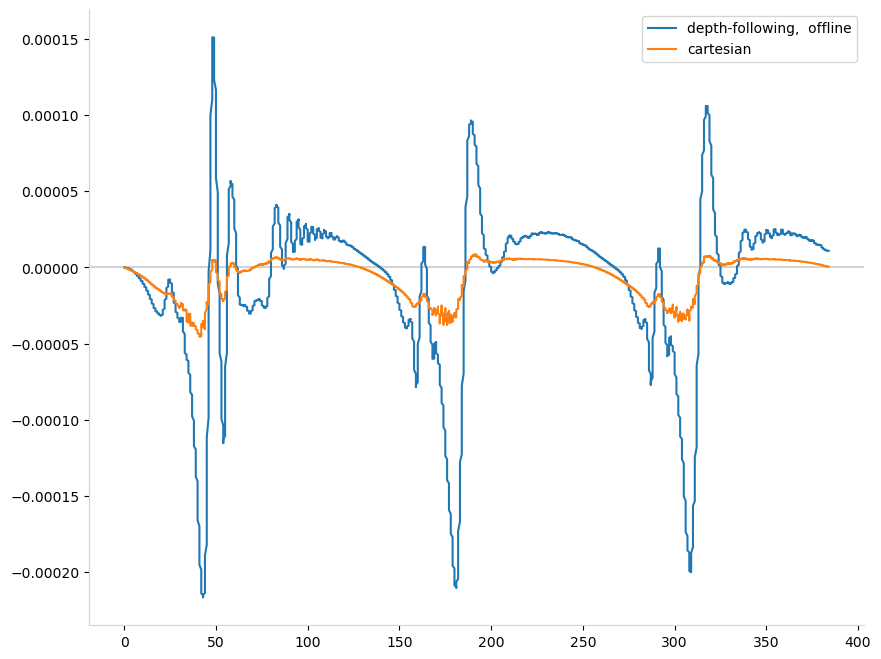

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
axes_styling(ax)
ax.axhline(0, color="lightgray")

t = ds.time/(60*60*24*1e9)
ax.plot(t,FormstressH1, label=r"depth-following,  offline")
#ax.plot(t,FormstressH3, label=r"depth-following,  online")
#ax.plot(t,FormstressH2, label=r"depth-following, $\nabla$H")

ax.plot(t,FormstressX, label="cartesian")  # free surface
#ax.plot(t,Formstressx, label="cartesian, rigid lid", ls="--")
ax.legend()

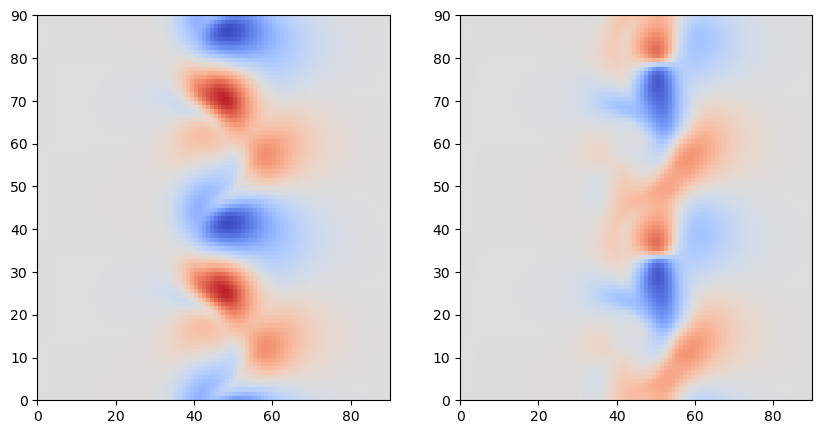

In [28]:
FSx = formstressX.mean("time")
FSh = formstressH1.mean("time")

fig, [axx, axh] = plt.subplots(ncols=2, figsize=(10,5))
vmax = np.max([np.abs(FSx), np.abs(FSh)])


axx.pcolormesh(FSx, vmin=-vmax, vmax=vmax, cmap="coolwarm")
axh.pcolormesh(FSh, vmin=-vmax, vmax=vmax, cmap="coolwarm")

### Form stress integrert langs kontur, vektet med konturtykkelse

In [29]:
idxs = np.arange(len(ds.xC))#np.arange(xstart, xstop)

g = params["gravitational_acceleration"]
detadx = ds.detadx 
detady = ds.detady
dh = hgrad.dh

FSlist = []
Hs = []
idy = int(params["lam"]/params["dy"]*0.5)
for idx in idxs:
    H = ds.h.isel(time=1,xC=idx, yC=idy).values
    
    contour = depth_following_contour(params, H)
    cL = contour.dl.sum(dim=("j")).values
    
    dht = dh.interp(yC=contour.y, xC=contour.x)
    detadxt = detadx.interp(yC=contour.y, xF=contour.x)
    detadyt = detady.interp(yF=contour.y, xC=contour.x)
    
    fs = -g*H*(detadxt*contour.dtdx+detadyt*contour.dtdy)/dht 
    FS = (fs*contour.dl).sum(dim="j")

    FSlist.append(FS)
    Hs.append(H)
    
dh = np.gradient(np.array(Hs))
results = xr.Dataset()
results["lineint"] = xr.concat(FSlist, dim="H")
results["dh"] = (["H"], dh)


FSH = (results.lineint*results.dh).sum("H")/area

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:131: RuntimeWarning: invalid value encountered in arctanh
  x0 = XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:137: RuntimeWarning: invalid value encountered in arctanh
  return x - (XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1) + corr)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:139: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  xt = fsolve(implicit_eq, np.array([x0]))[0]  # Solve for x
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/itf-fi-ml/home/alsj

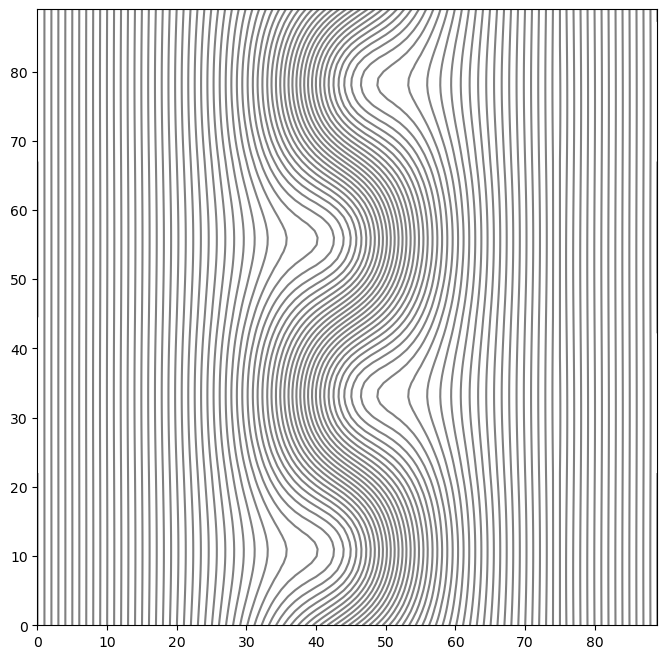

In [30]:
fig, ax = plt.subplots(figsize=(8,8))
ax.contour(ds.h.isel(time=1), levels=Hs, colors="grey")

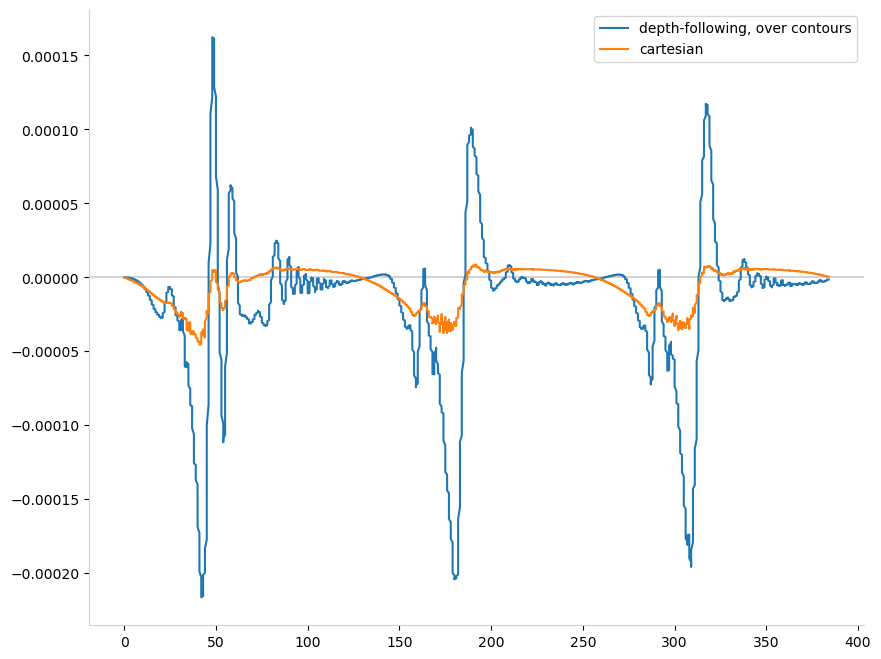

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
axes_styling(ax)
ax.axhline(0, color="lightgray")


t = ds.time/(60*60*24*1e9)
ax.plot(t,FSH, label=r"depth-following, over contours")
#ax.plot(t,FormstressH1, label=r"depth-following,  over xy")
ax.plot(t,FormstressX, label="cartesian")  # free surface
#ax.plot(t,Formstressx, label="cartesian, rigid lid", ls="--")
ax.legend()

### Virvlingsflukser integrert langs kontur, vektet med konturtykkelse

In [32]:
nonlin = -ds.duvhdx.mean(["xC", "yC"])

In [33]:
vortu = ds.omegau
vortv = ds.omegav
dh = hgrad.dh

fluxlist = []
Hs = []
idy = int(params["lam"]/params["dy"]*0.5)
for idx in idxs:
    H = ds.h.isel(time=1,xC=idx, yC=idy).values
    
    contour = depth_following_contour(params, H)
    cL = contour.dl.sum(dim=("j")).values
    
    dht = dh.interp(yC=contour.y, xC=contour.x)
    vortut = vortu.interp(xF=contour.x, yF=contour.y)
    vortvt = vortv.interp(xF=contour.x, yF=contour.y)
    vortUt = (vortut * contour.dtdy - vortvt * contour.dtdx)/dht 

    flux = (vortUt*contour.dl).sum(dim="j")

    fluxlist.append(flux)
    Hs.append(H)
    
dh = np.gradient(np.array(Hs))
fluxes = xr.Dataset()
fluxes["lineint"] = xr.concat(fluxlist, dim="H")
fluxes["dh"] = (["H"], dh)


totflux = (fluxes.lineint*fluxes.dh).sum("H")/area

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:131: RuntimeWarning: invalid value encountered in arctanh
  x0 = XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:137: RuntimeWarning: invalid value encountered in arctanh
  return x - (XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1) + corr)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:139: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  xt = fsolve(implicit_eq, np.array([x0]))[0]  # Solve for x
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/itf-fi-ml/home/alsj

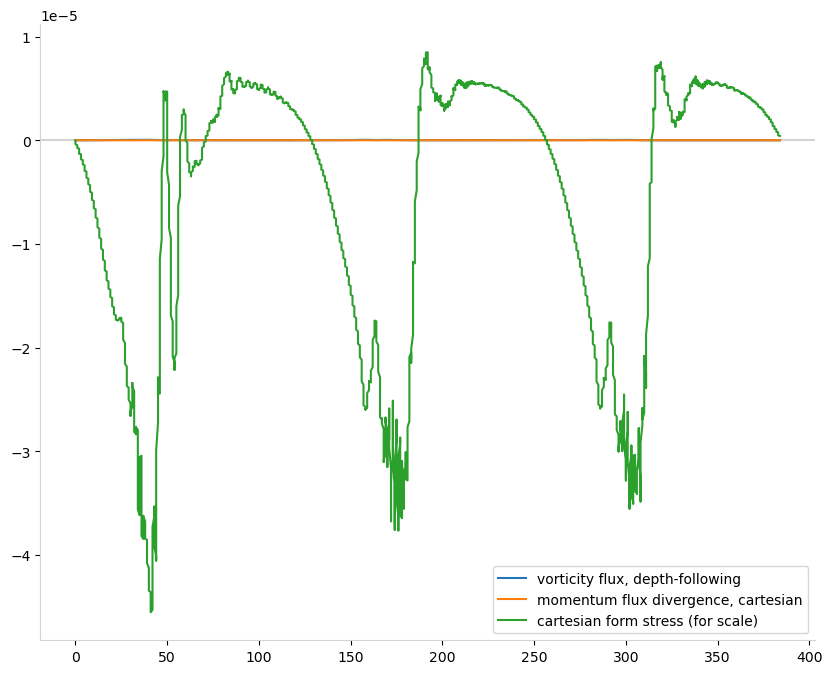

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
axes_styling(ax)
ax.axhline(0, color="lightgray")


t = ds.time/(60*60*24*1e9)
ax.plot(t,totflux, label=r"vorticity flux, depth-following")
#ax.plot(t,totflux+FSH, label=r"vorticity flux + form stress, depth-following")
ax.plot(t,nonlin, label=r"momentum flux divergence, cartesian")
ax.plot(t,FormstressX, label="cartesian form stress (for scale)")

ax.legend()

### Compare form stress with bottom stress


In [35]:
bottomstressx = -ds.v.mean(["xC", "yF"])*params["R"]

In [36]:
u = ds.u
v = ds.v
dh = hgrad.dh

vlist = []
Hs = []
idy = int(params["lam"]/params["dy"]*0.5)
for idx in idxs:
    H = ds.h.isel(time=1,xC=idx, yC=idy).values
    
    contour = depth_following_contour(params, H)
    cL = contour.dl.sum(dim=("j")).values
    
    dht = dh.interp(yC=contour.y, xC=contour.x)
    ut = u.interp(xF=contour.x, yC=contour.y)
    vt = v.interp(xC=contour.x, yF=contour.y)
    Vt = (ut * contour.dtdx + vt * contour.dtdy)/dht 

    V = (Vt*contour.dl).sum(dim="j")

    vlist.append(V)
    Hs.append(H)
    
dh = np.gradient(np.array(Hs))
Vs = xr.Dataset()
Vs["lineint"] = xr.concat(vlist, dim="H")
Vs["dh"] = (["H"], dh)

bottomstressH = -params["R"]*(Vs.lineint*fluxes.dh).sum("H")/area

/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:131: RuntimeWarning: invalid value encountered in arctanh
  x0 = XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:137: RuntimeWarning: invalid value encountered in arctanh
  return x - (XC + W / np.pi * np.arctanh((2 * (H - DB)) / DS - 1) + corr)
/itf-fi-ml/home/alsjur/temporal-topo-flow/slope/code/utils.py:139: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  xt = fsolve(implicit_eq, np.array([x0]))[0]  # Solve for x
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:562: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x.values)
/itf-fi-ml/home/alsjur/.conda/envs/general/lib/python3.12/site-packages/xarray/core/missing.py:563: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x.values)
/itf-fi-ml/home/alsj

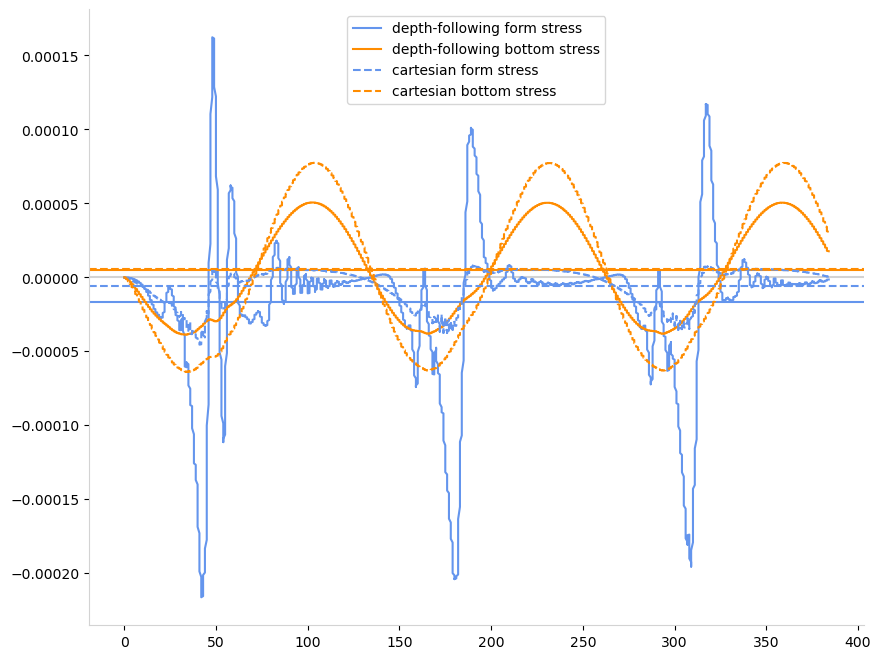

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
axes_styling(ax)
ax.axhline(0, color="lightgray")

t = ds.time/(60*60*24*1e9)
tn = int(params["T"]/params["outputtime"])

ax.plot(t,FSH, label="depth-following form stress", color="cornflowerblue")  
ax.axhline(FSH.isel(time=slice(-2*tn,None)).mean("time"), color="cornflowerblue")
ax.plot(t,bottomstressH, label="depth-following bottom stress", color="darkorange") 
ax.axhline(bottomstressH.isel(time=slice(-2*tn,None)).mean("time"), color="darkorange")

ax.plot(t,FormstressX, label="cartesian form stress", color="cornflowerblue", ls="--")  
ax.axhline(FormstressX.isel(time=slice(-2*tn,None)).mean("time"), color="cornflowerblue", ls="--")
ax.plot(t,bottomstressx, label="cartesian bottom stress", color="darkorange", ls="--") 
ax.axhline(bottomstressx.isel(time=slice(-2*tn,None)).mean("time"), color="darkorange", ls="--")



ax.legend()
#ax.set_ylim(-1e-7,1e-7)